In [94]:
from pandas_datareader import data as pdr
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import yfinance as yf

In [109]:
df = pdr.get_data_yahoo("GOOGL", start="2017-01-01", end="2021-12-01")
df = df[['High', 'Low', 'Open', 'Volume', 'Close']]
df.reset_index(inplace=True)
df.head()

,Date,High,Low,Open,Volume,Close
0,2017-01-03,811.440002,796.890015,800.619995,1959000,808.010010
1,2017-01-04,813.429993,804.109985,809.890015,1515300,807.770020
2,2017-01-05,813.739990,805.919983,807.500000,1340500,813.020020
3,2017-01-06,828.960022,811.500000,814.989990,2017100,825.210022
4,2017-01-09,830.429993,821.619995,826.369995,1408900,827.179993


In [110]:
import numpy as np
from sklearn.preprocessing import StandardScaler

dates = df['Date']
df = df.drop('Date', axis=1)
scaler = StandardScaler()
final_df = scaler.fit_transform(df)

In [8]:
def _create_dataset(dataset, future_days, past_days):
    X_train, y_train = [], []
    for i in range(past_days, len(dataset) - future_days + 1):
        X_train.append(dataset[i - past_days:i, 0:dataset.shape[1] - 1])
        y_train.append(dataset[i + future_days - 1:i + future_days, 4])

    X_train, y_train = np.array(X_train), np.array(y_train)
    
    print('X_train shape == {}.'.format(X_train.shape))
    print('y_train shape == {}.'.format(y_train.shape))

    return X_train, y_train

In [9]:
X_train, y_train = _create_dataset(final_df, 30, 100)

X_train shape == (1109, 100, 4).
y_train shape == (1109, 1).


In [116]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

model = Sequential()
model.add(LSTM(64, activation='relu', input_shape=(100, final_df.shape[1]-1), return_sequences=True))
model.add(LSTM(10, activation='relu', return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(1))

model.compile(optimizer = Adam(learning_rate=0.01), loss='mean_squared_error')
model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_18 (LSTM)              (None, 100, 64)           17664     
                                                                 
 lstm_19 (LSTM)              (None, 10)                3000      
                                                                 
 dropout_9 (Dropout)         (None, 10)                0         
                                                                 
 dense_9 (Dense)             (None, 1)                 11        
                                                                 
Total params: 20,675
Trainable params: 20,675
Non-trainable params: 0
_________________________________________________________________


In [117]:
# %%time
# early_stop = EarlyStopping(monitor='val_loss', min_delta=1e-10, patience=10, verbose=1)
# reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, verbose=1)
# model_cp = ModelCheckpoint(filepath='weights.h5', monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True)
# callbacks=[early_stop, reduce_lr, model_cp]
# shuffle=True

history = model.fit(X_train, y_train, epochs=30, batch_size=16, validation_split=0.1, verbose=1)

Epoch 1/30
63/63 [==============================] - 5s 48ms/step - loss: 361586.8125 - val_loss: 2616035072.0000
Epoch 2/30
63/63 [==============================] - 3s 44ms/step - loss: 0.1126 - val_loss: 57567200.0000
Epoch 3/30
63/63 [==============================] - 3s 43ms/step - loss: 0.0806 - val_loss: 378.6788
Epoch 4/30
63/63 [==============================] - 3s 42ms/step - loss: 0.0869 - val_loss: 1.9753
Epoch 5/30
63/63 [==============================] - 3s 48ms/step - loss: 0.0697 - val_loss: 0.3573
Epoch 6/30
63/63 [==============================] - 3s 46ms/step - loss: 0.0634 - val_loss: 0.2695
Epoch 7/30
63/63 [==============================] - 3s 50ms/step - loss: 0.0695 - val_loss: 0.9194
Epoch 8/30
63/63 [==============================] - 3s 48ms/step - loss: 0.1276 - val_loss: 0.1585
Epoch 9/30
63/63 [==============================] - 3s 48ms/step - loss: 0.0693 - val_loss: 0.1209
Epoch 10/30
63/63 [==============================] - 3s 49ms/step - loss: 0.0666 - val

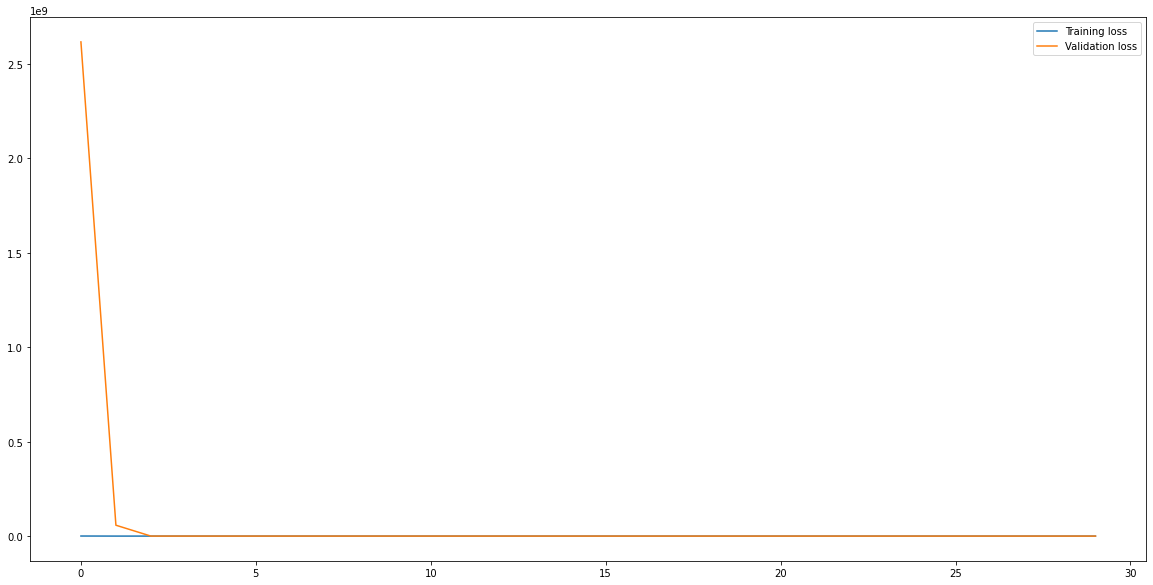

In [118]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()
plt.show()

In [33]:
y_train_copies = np.repeat(y_train, df.shape[1], axis=-1)
y_train_actual = scaler.inverse_transform(y_train_copies)[:,0]

predictions_future = model.predict(X_train[-30:])
predictions_train = model.predict(X_train[100:])

train_predict_copies = np.repeat(predictions_train, df.shape[1], axis=-1)
y_pred_train = scaler.inverse_transform(train_predict_copies)[:,0]

train_future_copies = np.repeat(predictions_future, df.shape[1], axis=-1)
y_pred_future = scaler.inverse_transform(train_future_copies)[:,0]

In [ ]:
from sklearn.metrics import mean_squared_error
import math

print(math.sqrt(mean_squared_error(y_train_actual, y_pred_train)))

In [41]:
datelist_future = pd.date_range(list(dates)[-1], periods=30, freq='1d').tolist()

PREDICTIONS_FUTURE = pd.DataFrame(y_pred_future, columns=['Close']).set_index(pd.Series(datelist_future))
PREDICTION_TRAIN = pd.DataFrame(y_pred_train, columns=['Close']).set_index(pd.Series(dates[2 * 100 + 30 -1:]))

# Convert <datetime.date> to <Timestamp> for PREDCITION_TRAIN
#PREDICTION_TRAIN.index = PREDICTION_TRAIN.index.to_series().apply(datetime_to_timestamp)

PREDICTION_TRAIN.head(3)

,Close
Date,
2017-11-29,1094.733032
2017-11-30,1098.156250
2017-12-01,1097.828857


In [86]:
df

,High,Low,Open,Volume,Close
0,811.440002,796.890015,800.619995,1959000,808.010010
1,813.429993,804.109985,809.890015,1515300,807.770020
2,813.739990,805.919983,807.500000,1340500,813.020020
3,828.960022,811.500000,814.989990,2017100,825.210022
4,830.429993,821.619995,826.369995,1408900,827.179993
...,...,...,...,...,...
1233,2924.989990,2887.459961,2909.469971,902000,2922.399902
1234,2891.149902,2836.850098,2886.969971,1523500,2843.659912
1235,2925.949951,2877.870117,2880.000000,1629800,2910.610107
1236,2920.000000,2832.030029,2900.169922,2103400,2837.949951


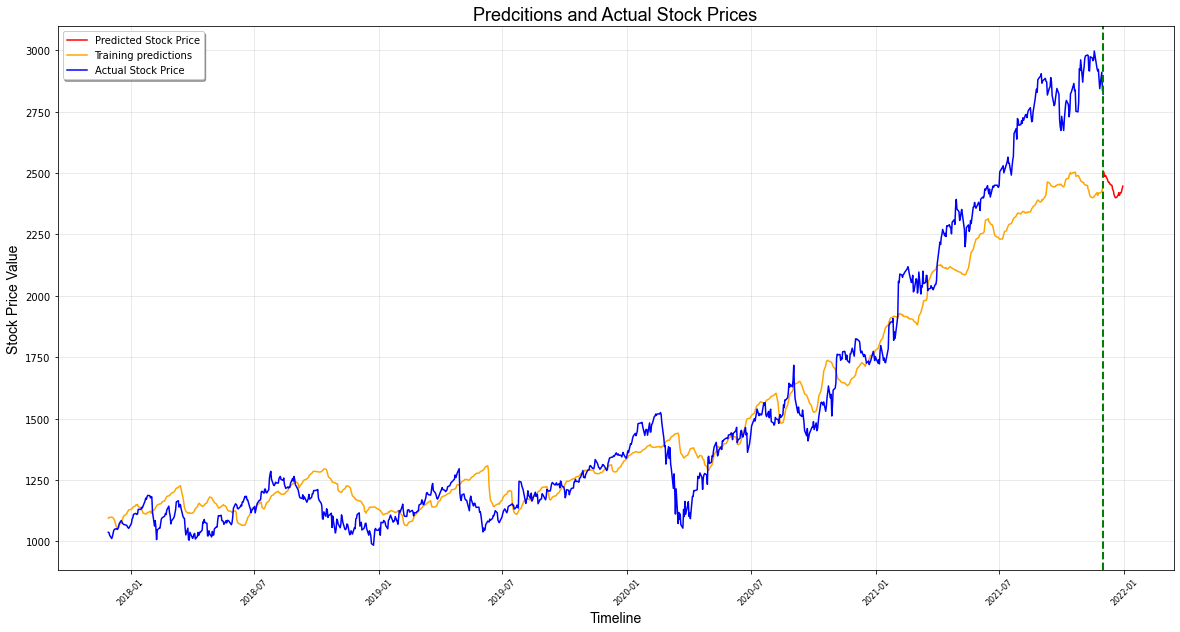

In [113]:
# Set plot size 
from pylab import rcParams
rcParams['figure.figsize'] = 20, 10

# Plot parameters
START_DATE_FOR_PLOTTING = '2017-11-29'

dates = list(dates)
df['Date'] = dates
df.set_index('Date', inplace=True)
plt.plot(PREDICTIONS_FUTURE.index, PREDICTIONS_FUTURE['Close'], color='r', label='Predicted Stock Price')
plt.plot(PREDICTION_TRAIN.loc[START_DATE_FOR_PLOTTING:].index, PREDICTION_TRAIN.loc[START_DATE_FOR_PLOTTING:]['Close'], color='orange', label='Training predictions')
plt.plot(df.loc[START_DATE_FOR_PLOTTING:].index, df.loc[START_DATE_FOR_PLOTTING:]['Close'], color='b', label='Actual Stock Price')

plt.axvline(x = min(PREDICTIONS_FUTURE.index), color='green', linewidth=2, linestyle='--')

plt.grid(which='major', color='#cccccc', alpha=0.5)

plt.legend(shadow=True)
plt.title('Predcitions and Actual Stock Prices', family='Arial', fontsize=18)
plt.xlabel('Timeline', family='Arial', fontsize=14)
plt.ylabel('Stock Price Value', family='Arial', fontsize=14)
plt.xticks(rotation=45, fontsize=8)
plt.show()